In [1]:
import sys
import os
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as mcolors

# silence warnings
import warnings

warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
sys.path.append("../")
from tesorai_search import data_parsing_utils

/fs/home/rlopez/miniconda/dev/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
_DATA_DIR = "../data/benchmark_results/"
_BENCHMARKS = [
    "bekker_jensen",
    "bassani_sternberg",
    "nowatzky",
    "williams/1_cells",
    "williams/3_cells",
    "williams/10_cells",
    "williams/50_cells",
]


def get_benchmark_results(benchmark):
    benchmark_results = {
        "MaxQuant": set(
            data_parsing_utils.get_maxquant_peptides(
                _DATA_DIR + f"{benchmark}/maxquant/"
            )
        ),
        "Proteome Discoverer": set(
            data_parsing_utils.get_pd_peptides(
                _DATA_DIR + f"{benchmark}/proteome_discoverer/peptides.xlsx"
            )
        ),
        "FragPipe": set(
            data_parsing_utils.get_fragpipe_peptides(
                _DATA_DIR + f"{benchmark}/fragpipe/peptides.tsv"
            )
        ),
        "PEAKS": set(
            data_parsing_utils.get_peaks_peptides(
                _DATA_DIR + f"{benchmark}/peaks/peptides.csv"
            )
        ),
        "Tesorai": set(
            data_parsing_utils.get_tesorai_peptides(
                _DATA_DIR + f"{benchmark}/tesorai/pep_fdr.csv"
            )
        ),
    }
    return benchmark_results

In [4]:
all_peptides = {}
for benchmark in _BENCHMARKS:
    print(f"Processing benchmark: {benchmark}")
    all_peptides[benchmark] = get_benchmark_results(benchmark)

Processing benchmark: bekker_jensen
Found file msms.txt in ../data/benchmark_results/bekker_jensen/maxquant/


Found 169476 peptides by maxquant from 436857 unique rows
Found 190362 peptides by PD from 207171 unique rows
Found 174795 peptides by fragpipe from 174795 unique rows
Found 170604 peptides by PEAKS from 187147 unique rows
Found 183147 peptides by TS
Processing benchmark: bassani_sternberg
Found file msms.txt in ../data/benchmark_results/bassani_sternberg/maxquant/
Found 22166 peptides by maxquant from 182392 unique rows
Found 35882 peptides by PD from 37941 unique rows
Found 39410 peptides by fragpipe from 39410 unique rows
Found 44396 peptides by PEAKS from 49774 unique rows
Found 47393 peptides by TS
Processing benchmark: nowatzky
Found file msms.txt in ../data/benchmark_results/nowatzky/maxquant/
Found 3677 peptides by maxquant from 6544 unique rows
Found 8333 peptides by PD from 8906 unique rows
Found 10848 peptides by fragpipe from 10848 unique rows
Found 11255 peptides by PEAKS from 12198 unique rows
Found 11787 peptides by TS
Processing benchmark: williams/1_cells
Found file pe

In [8]:
counts = {}
for benchmark, results in all_peptides.items():
    counts_per_search_engine = {
        search_engine: len(peptides) for search_engine, peptides in results.items()
    }
    counts_per_search_engine["union"] = len(set.union(*results.values()))
    counts[benchmark] = counts_per_search_engine

raw_table = pd.DataFrame(counts).T
raw_table

,MaxQuant,Proteome Discoverer,FragPipe,PEAKS,Tesorai,union
bekker_jensen,169476,190362,174795,170604,183147,224741
bassani_sternberg,22166,35882,39410,44396,47393,57935
nowatzky,3677,8333,10848,11255,11787,14107
williams/1_cells,1626,1964,1910,1892,2472,2761
williams/3_cells,2758,3435,3611,4048,4301,5114
williams/10_cells,4488,5382,5620,6130,6614,7766
williams/50_cells,7890,10482,10720,12285,13030,15472


In [9]:
normalized_raw_table = raw_table.div(raw_table["union"], axis=0)
# Display only 2 significant digits
pd.options.display.float_format = "{:,.0f}%".format

normalized_raw_table * 100

,MaxQuant,Proteome Discoverer,FragPipe,PEAKS,Tesorai,union
bekker_jensen,75%,85%,78%,76%,81%,100%
bassani_sternberg,38%,62%,68%,77%,82%,100%
nowatzky,26%,59%,77%,80%,84%,100%
williams/1_cells,59%,71%,69%,69%,90%,100%
williams/3_cells,54%,67%,71%,79%,84%,100%
williams/10_cells,58%,69%,72%,79%,85%,100%
williams/50_cells,51%,68%,69%,79%,84%,100%


In [10]:
# Custom CMAP
# 1. Get the original colormap
original_cmap = plt.get_cmap("RdBu")

# 2. Define anchor points and sample original colors at key locations
# We need the Red at 0.0, orange at 0.5, and Green at 1.0 from the original map
nodes = [0.0, 0.1, 0.45, 0.70, 0.8, 0.9, 1.0]
colors_at_key_points = original_cmap([0.0, 0.25, 0.5, 0.75, 1.0])  # Get RGBA values

# Define the colors corresponding to our desired nodes
node_colors = [
    colors_at_key_points[0],
    colors_at_key_points[0],
    colors_at_key_points[1],
    colors_at_key_points[2],
    colors_at_key_points[3],
    colors_at_key_points[4],
    colors_at_key_points[4],
]

# 3. Construct the colormap dictionary (cdict)
# Each color channel (red, green, blue) needs its own list of anchor points.
cdict = {"red": [], "green": [], "blue": []}  # Alpha is ignored here but could be added

for i, node in enumerate(nodes):
    rgba = node_colors[i]
    cdict["red"].append((node, rgba[0], rgba[0]))
    cdict["green"].append((node, rgba[1], rgba[1]))
    cdict["blue"].append((node, rgba[2], rgba[2]))

# 4. Create the new custom colormap
custom_cmap = mcolors.LinearSegmentedColormap("custom_RdYlGn", cdict)

In [11]:
df = normalized_raw_table * 100
df.drop("union", axis=1, inplace=True)
# Create average row at the bottom
df.loc["Average"] = df.mean()

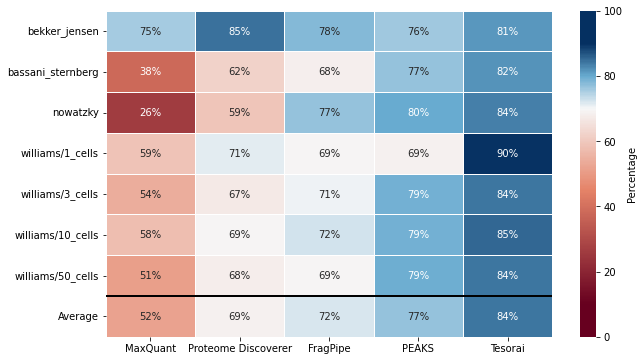

In [12]:
# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    df,
    annot=df.applymap(lambda x: f"{x:.0f}%" if not pd.isna(x) else ""),
    cmap=custom_cmap,
    cbar=True,
    cbar_kws={"label": "Percentage"},
    fmt="",
    linewidths=0.5,
    vmin=0,
    vmax=100,
)

# Add a line to separate the last row
plt.axhline(y=len(df) - 1, color="black", linewidth=2)

cbar = plt.gca().collections[0].colorbar
plt.show()